In [1]:
# TODO: Scale dataset for predicting 15 months ahead

import pandas as pd
import os

dyad_df = pd.read_parquet('../data_dyad_monthly_v0.6.parquet')
# get only dyads from Jan 2016 to Jan 2019
# to date
dyad_df['date'] = pd.to_datetime(dyad_df['date'])
# dyad_df = dyad_df[
#     (dyad_df['date'] >= pd.Timestamp(year=2016, month=7, day=1)) &
#     (dyad_df['date'] <= pd.Timestamp(year=2019, month=1, day=1))]
# reset index
dyad_df.reset_index(drop=True, inplace=True)
print(dyad_df.columns)
dyad_df.info()


Index(['month_id', 'date', 'country_id_a', 'country_id_b', 'ccode_a',
       'ccode_b', 'a_country_name', 'b_country_name', 'min_dist', 'a_is_major',
       ...
       'a_ged_sb_y_14', 'b_ged_sb_y_14', 'a_ged_sb_y_15', 'b_ged_sb_y_15',
       'a_ged_sb_y_16', 'b_ged_sb_y_16', 'a_ged_sb_y_17', 'b_ged_sb_y_17',
       'a_ged_sb_y_18', 'b_ged_sb_y_18'],
      dtype='object', length=304)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1870040 entries, 0 to 1870039
Columns: 304 entries, month_id to b_ged_sb_y_18
dtypes: bool(2), datetime64[ns](1), float64(246), int64(53), object(2)
memory usage: 4.2+ GB


In [24]:
# print(dyad_df.columns) # all 
# drop columns for dep var a_ged_sb and b_ged_sb
base_shift = 3
# columns from ged_sb_y_4 to ged_sb_y_18
months_ahead_columns = {f'ged_sb_y_{i}' for i in
                        range(1 + base_shift, 15 + base_shift)}  # drop all except for the last one
months_ahead_columns_c = [f'a_{col}' for col in months_ahead_columns] + [f'b_{col}' for col in months_ahead_columns]
# drop all months_ahead_columns
dyad_df.drop(columns=months_ahead_columns_c, inplace=True)

In [2]:
dyad_df.info()
# get only 100 first columns
dyad_df.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1870040 entries, 0 to 1870039
Columns: 304 entries, month_id to b_ged_sb_y_18
dtypes: bool(2), datetime64[ns](1), float64(246), int64(53), object(2)
memory usage: 4.2+ GB


,month_id,date,country_id_a,country_id_b,ccode_a,ccode_b,a_country_name,b_country_name,min_dist,a_is_major,...,a_ged_sb_y_14,b_ged_sb_y_14,a_ged_sb_y_15,b_ged_sb_y_15,a_ged_sb_y_16,b_ged_sb_y_16,a_ged_sb_y_17,b_ged_sb_y_17,a_ged_sb_y_18,b_ged_sb_y_18
0,121,1990-01-01,1,2,110,115,Guyana,Surinam,0.000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,121,1990-01-01,1,4,110,101,Guyana,Venezuela,0.000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,121,1990-01-01,1,7,110,160,Guyana,Argentina,2601.423340,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,121,1990-01-01,1,9,110,140,Guyana,Brazil,0.000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,121,1990-01-01,1,39,110,200,Guyana,United Kingdom,6774.020442,False,...,0.0,2.0,0.0,3.0,0.0,7.0,0.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,121,1990-01-01,7,55,160,522,Argentina,Djibouti,11087.574326,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,121,1990-01-01,7,58,160,712,Argentina,Mongolia,15811.603216,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,121,1990-01-01,7,59,160,625,Argentina,Sudan,9180.070229,True,...,0.0,328.0,0.0,570.0,0.0,60.0,0.0,14.0,0.0,0.0
98,121,1990-01-01,7,60,160,645,Argentina,Iraq,11745.478447,True,...,0.0,19503.0,0.0,128.0,0.0,164.0,0.0,0.0,0.0,84.0


In [26]:
# from utilities import views_month_id_to_date
# 
# # load benchmark model
prediction_year = 2018  # 2018-2019
# model_names = {
#     "bootstrap": "bm_cm_bootstrap_expanded_",
#     "poisson": "bm_cm_last_historical_poisson_expanded_",
# }
# benchmark_model = pd.read_parquet(f'Benchmarks/{model_names["bootstrap"]}{prediction_year}.parquet')
# # there is 20 draws per each country per each month. Get the mean of the draws
# benchmark_model = benchmark_model.groupby(['month_id', 'country_id']).mean().reset_index()
# # add date column
# benchmark_model['date'] = views_month_id_to_date(benchmark_model['month_id'])
# benchmark_model

In [27]:
# from sklearn.preprocessing import OneHotEncoder
# 
# encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# countries_encoded = encoder.fit_transform(dyad_df[['ccode_a', 'ccode_b']])
# countries_encoded = encoder.transform(dyad_df[['ccode_a', 'ccode_b']])
# countries_encoded = pd.DataFrame(countries_encoded, columns=encoder.get_feature_names(['ccode_a', 'ccode_b']))
# countries_encoded
# # trasnform country_id_a and country_id_b to one hot encoding and remove the original columns
# country_a_and_b_ids = dyad_df[dyad_df['ccode_a'], dyad_df['ccode_b']]

# country_a_and_b_ids = dyad_df[['ccode_a', 'ccode_b']]
# dyad_df = pd.get_dummies(dyad_df, columns=['ccode_a', 'ccode_b'], drop_first=False, dtype=int)
# # merge back country_id_a and country_id_b
# dyad_df = pd.concat([dyad_df, country_a_and_b_ids], axis=1)
# dyad_df

In [28]:
cut_year = prediction_year - 2  # 2016

features_to_cut = pd.Timestamp(year=cut_year, month=10, day=1)  # 2016-Oct-01

# Splitting the dataset
train_df = dyad_df[dyad_df['date'] < features_to_cut]
# test_df is one year from Oct 2016 to Oct 2017
test_df = dyad_df[
    (dyad_df['date'] >= pd.Timestamp(year=cut_year, month=10, day=1)) &  # oct 2016 predicts Jan 2018
    (dyad_df['date'] < pd.Timestamp(year=cut_year + 1, month=10, day=1))]  # oct 2017 predicts Jan 2019


In [29]:
list(train_df.columns)

['month_id',
 'date',
 'country_id_a',
 'country_id_b',
 'ccode_a',
 'ccode_b',
 'a_country_name',
 'b_country_name',
 'min_dist',
 'a_is_major',
 'b_is_major',
 'a_ged_sb',
 'b_ged_sb',
 'has_active_riv',
 'years_since_riv_start',
 'principal',
 'asymmetric_principal',
 'positional',
 'spatial',
 'ideological',
 'interventionary',
 'a_ged_ns',
 'a_ged_os',
 'a_acled_sb',
 'a_acled_sb_count',
 'a_acled_os',
 'a_ged_sb_tsum_24',
 'a_wdi_sp_pop_totl',
 'a_ged_sb_tlag_1',
 'a_ged_sb_tlag_2',
 'a_ged_sb_tlag_3',
 'a_ged_sb_tlag_4',
 'a_ged_sb_tlag_5',
 'a_ged_sb_tlag_6',
 'a_ged_os_tlag_1',
 'a_wdi_ag_lnd_frst_k2',
 'a_wdi_dt_oda_odat_pc_zs',
 'a_wdi_ms_mil_xpnd_gd_zs',
 'a_wdi_ms_mil_xpnd_zs',
 'a_wdi_nv_agr_totl_kd',
 'a_wdi_nv_agr_totl_kn',
 'a_wdi_ny_gdp_pcap_kd',
 'a_wdi_sp_dyn_le00_in',
 'a_wdi_se_enr_prim_fm_zs',
 'a_wdi_se_enr_prsc_fm_zs',
 'a_wdi_se_prm_nenr',
 'a_wdi_sh_sta_maln_zs',
 'a_wdi_sh_sta_stnt_zs',
 'a_wdi_sl_tlf_totl_fe_zs',
 'a_wdi_sm_pop_refg_or',
 'a_wdi_sm_pop_netm

In [30]:

TARGET_COLUMNS = ['a_ged_sb_y_18', 'b_ged_sb_y_18']

# Explicitly list columns to be dropped before scaling
columns_to_drop = ['month_id',
                   'date',
                   'country_id_a',
                   'country_id_b',
                   'ccode_a',
                   'ccode_b',
                   'a_country_name',
                   'b_country_name']

# drop categorical columns
categorical = ['has_active_riv', 'principal',
               'asymmetric_principal',
               'positional',
               'spatial',
               'ideological',
               'interventionary', 'a_is_major', 'b_is_major']

columns_to_drop.extend(categorical)
columns_to_drop.extend(['a_country_name', 'b_country_name'])

# Also, drop one-hot encoded country identifiers if they are already in the dataframe
columns_to_drop.extend(dyad_df.filter(regex='^country_id_a_').columns.tolist())
columns_to_drop.extend(dyad_df.filter(regex='^country_id_b_').columns.tolist())

# columns_to_drop.extend(dyad_df.filter(regex='decay|splag|vdem').columns.tolist())
# decay and vdem are already scaled. Splag is not scaled
columns_to_drop.extend(dyad_df.filter(regex='decay|vdem').columns.tolist())

# Determine numeric columns by excluding the ones to drop from the dataframe
numeric_columns = dyad_df.drop(columns=columns_to_drop).columns.tolist()
list(numeric_columns)

['min_dist',
 'a_ged_sb',
 'b_ged_sb',
 'years_since_riv_start',
 'a_ged_ns',
 'a_ged_os',
 'a_acled_sb',
 'a_acled_sb_count',
 'a_acled_os',
 'a_ged_sb_tsum_24',
 'a_wdi_sp_pop_totl',
 'a_ged_sb_tlag_1',
 'a_ged_sb_tlag_2',
 'a_ged_sb_tlag_3',
 'a_ged_sb_tlag_4',
 'a_ged_sb_tlag_5',
 'a_ged_sb_tlag_6',
 'a_ged_os_tlag_1',
 'a_wdi_ag_lnd_frst_k2',
 'a_wdi_dt_oda_odat_pc_zs',
 'a_wdi_ms_mil_xpnd_gd_zs',
 'a_wdi_ms_mil_xpnd_zs',
 'a_wdi_nv_agr_totl_kd',
 'a_wdi_nv_agr_totl_kn',
 'a_wdi_ny_gdp_pcap_kd',
 'a_wdi_sp_dyn_le00_in',
 'a_wdi_se_enr_prim_fm_zs',
 'a_wdi_se_enr_prsc_fm_zs',
 'a_wdi_se_prm_nenr',
 'a_wdi_sh_sta_maln_zs',
 'a_wdi_sh_sta_stnt_zs',
 'a_wdi_sl_tlf_totl_fe_zs',
 'a_wdi_sm_pop_refg_or',
 'a_wdi_sm_pop_netm',
 'a_wdi_sm_pop_totl_zs',
 'a_wdi_sp_dyn_imrt_in',
 'a_wdi_sh_dyn_mort_fe',
 'a_wdi_sp_pop_14_fe_zs',
 'a_wdi_sp_pop_1564_fe_zs',
 'a_wdi_sp_pop_65up_fe_zs',
 'a_wdi_sp_pop_grow',
 'a_wdi_sp_urb_totl_in_zs',
 'a_splag_wdi_sl_tlf_totl_fe_zs',
 'a_splag_wdi_sm_pop_refg

In [31]:
# from sklearn.preprocessing import StandardScaler
# 
# TARGET_COLUMNS = ['a_ged_sb', 'b_ged_sb']
# 
# # Initialize the scaler using only the training data
# scaler = StandardScaler().fit(train_df.drop(TARGET_COLUMNS, axis=1))
# 
# # Apply the transformations to both the training and test sets
# train_df_scaled = scaler.transform(train_df.drop(TARGET_COLUMNS, axis=1))
# test_df_scaled = scaler.transform(test_df.drop(TARGET_COLUMNS, axis=1))
# 
# # Reconstruct the dataframes with normalized features and the targets
# train_df = pd.DataFrame(train_df_scaled, columns=train_df.columns.drop(TARGET_COLUMNS))
# train_df[TARGET_COLUMNS] = train_df[TARGET_COLUMNS]
# 
# test_df = pd.DataFrame(test_df_scaled, columns=test_df.columns.drop(TARGET_COLUMNS))
# test_df[TARGET_COLUMNS] = test_df[TARGET_COLUMNS]

In [32]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler using only the training data
# scaler = StandardScaler().fit(train_df[numeric_columns])

# # Apply the transformations to both the training and test sets
# train_df_scaled = scaler.transform(train_df.drop(TARGET_COLUMNS, axis=1))
# test_df_scaled = scaler.transform(test_df.drop(TARGET_COLUMNS, axis=1))
# 
# # Reconstruct the dataframes with normalized features and the targets
# train_df = pd.DataFrame(train_df_scaled, columns=train_df.columns.drop(TARGET_COLUMNS))
# train_df[TARGET_COLUMNS] = train_df[TARGET_COLUMNS]
# 
# test_df = pd.DataFrame(test_df_scaled, columns=test_df.columns.drop(TARGET_COLUMNS))
# test_df[TARGET_COLUMNS] = test_df[TARGET_COLUMNS]

In [33]:
# get last 2 years of data
hist_df = dyad_df[
    (dyad_df['date'] >= pd.Timestamp(year=cut_year, month=1, day=1)) &  # 2016
    (dyad_df['date'] < pd.Timestamp(year=cut_year + 2, month=1, day=1))]  # 2018
hist_df.reset_index(drop=True, inplace=True)
hist_df = hist_df[numeric_columns]
boolean_columns = [col for col in hist_df.columns if hist_df[col].dtype == bool]
numeric_columns

['min_dist',
 'a_ged_sb',
 'b_ged_sb',
 'years_since_riv_start',
 'a_ged_ns',
 'a_ged_os',
 'a_acled_sb',
 'a_acled_sb_count',
 'a_acled_os',
 'a_ged_sb_tsum_24',
 'a_wdi_sp_pop_totl',
 'a_ged_sb_tlag_1',
 'a_ged_sb_tlag_2',
 'a_ged_sb_tlag_3',
 'a_ged_sb_tlag_4',
 'a_ged_sb_tlag_5',
 'a_ged_sb_tlag_6',
 'a_ged_os_tlag_1',
 'a_wdi_ag_lnd_frst_k2',
 'a_wdi_dt_oda_odat_pc_zs',
 'a_wdi_ms_mil_xpnd_gd_zs',
 'a_wdi_ms_mil_xpnd_zs',
 'a_wdi_nv_agr_totl_kd',
 'a_wdi_nv_agr_totl_kn',
 'a_wdi_ny_gdp_pcap_kd',
 'a_wdi_sp_dyn_le00_in',
 'a_wdi_se_enr_prim_fm_zs',
 'a_wdi_se_enr_prsc_fm_zs',
 'a_wdi_se_prm_nenr',
 'a_wdi_sh_sta_maln_zs',
 'a_wdi_sh_sta_stnt_zs',
 'a_wdi_sl_tlf_totl_fe_zs',
 'a_wdi_sm_pop_refg_or',
 'a_wdi_sm_pop_netm',
 'a_wdi_sm_pop_totl_zs',
 'a_wdi_sp_dyn_imrt_in',
 'a_wdi_sh_dyn_mort_fe',
 'a_wdi_sp_pop_14_fe_zs',
 'a_wdi_sp_pop_1564_fe_zs',
 'a_wdi_sp_pop_65up_fe_zs',
 'a_wdi_sp_pop_grow',
 'a_wdi_sp_urb_totl_in_zs',
 'a_splag_wdi_sl_tlf_totl_fe_zs',
 'a_splag_wdi_sm_pop_refg

In [34]:
import matplotlib.pyplot as plt
import shutil

PLOT_FIGURES = False


def plot_column_distributions(dataframe, columns, folder='plots', img_size=(4, 3)):
    """
    Plot and save histograms for specified columns in a dataframe.

    Parameters:
    - dataframe: pandas DataFrame containing the data.
    - columns: List of column names to plot.
    - folder: String specifying the directory to save the plots.
    - img_size: Tuple specifying the size of the images.
    """
    import os
    # remove dir if exists
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder, exist_ok=True)

    skewed_columns = []
    other_columns = []

    for col in columns:
        if col.startswith('b_'):  # skip b_ columns
            continue

        # Check if the column exists in the dataframe to avoid KeyError
        if col in dataframe.columns:
            col_data = dataframe[col].dropna()

            # Log the minimum and maximum values of the column. Round to 2 decimal places.
            min_val = round(col_data.min(), 2)
            max_val = round(col_data.max(), 2)
            skewness = round(col_data.skew(), 2)

            cols = [col]
            if col.startswith('a_'):
                cols = [col, 'b_' + col[2:]]

            if skewness > 1:
                skewed_columns.extend(cols)
            else:
                other_columns.extend(cols)

            print(f"Column: {col} - Min: {min_val}, Max: {max_val} - Skew: {skewness}")
            if PLOT_FIGURES:
                plt.figure(figsize=img_size)
                col_data.hist(bins=12, alpha=0.75)
                plt.title(f"{col} - Min: {min_val}, Max: {max_val} - Skew: {skewness}")
                plt.xlabel('Value')
                plt.ylabel('Frequency')

                # Save the plot
                plt.savefig(f"{folder}/{col}.png", format='png', dpi=100)
                plt.close()  # Close the figure to free memory
        else:
            print(f"Column {col} not found in dataframe.")

    return skewed_columns, other_columns


# Usage:
skewed_cols, other_columns = plot_column_distributions(hist_df, numeric_columns)

Column: min_dist - Min: 0.0, Max: 17942.21 - Skew: 0.59
Column: a_ged_sb - Min: 0, Max: 17412 - Skew: 27.59
Column: years_since_riv_start - Min: 0, Max: 186 - Skew: 14.53
Column: a_ged_ns - Min: 0, Max: 2129 - Skew: 14.18
Column: a_ged_os - Min: 0, Max: 1832 - Skew: 14.55
Column: a_acled_sb - Min: 0, Max: 4309 - Skew: 5.96
Column: a_acled_sb_count - Min: 0, Max: 1702 - Skew: 9.72
Column: a_acled_os - Min: 0, Max: 2077 - Skew: 7.11
Column: a_ged_sb_tsum_24 - Min: 0, Max: 116713 - Skew: 9.52
Column: a_wdi_sp_pop_totl - Min: 278083, Max: 1387790000 - Skew: 3.26
Column: a_ged_sb_tlag_1 - Min: 0, Max: 17412 - Skew: 29.6
Column: a_ged_sb_tlag_2 - Min: 0, Max: 17412 - Skew: 29.38
Column: a_ged_sb_tlag_3 - Min: 0, Max: 17412 - Skew: 29.21
Column: a_ged_sb_tlag_4 - Min: 0, Max: 17412 - Skew: 29.29
Column: a_ged_sb_tlag_5 - Min: 0, Max: 17412 - Skew: 28.98
Column: a_ged_sb_tlag_6 - Min: 0, Max: 17412 - Skew: 28.42
Column: a_ged_os_tlag_1 - Min: 0, Max: 1832 - Skew: 14.33
Column: a_wdi_ag_lnd_frs

In [35]:
[col for col in skewed_cols if col not in dyad_df.columns]

[]

In [54]:
skewed_cols

['a_ged_sb',
 'b_ged_sb',
 'years_since_riv_start',
 'a_ged_ns',
 'b_ged_ns',
 'a_ged_os',
 'b_ged_os',
 'a_acled_sb',
 'b_acled_sb',
 'a_acled_sb_count',
 'b_acled_sb_count',
 'a_acled_os',
 'b_acled_os',
 'a_ged_sb_tsum_24',
 'b_ged_sb_tsum_24',
 'a_wdi_sp_pop_totl',
 'b_wdi_sp_pop_totl',
 'a_ged_sb_tlag_1',
 'b_ged_sb_tlag_1',
 'a_ged_sb_tlag_2',
 'b_ged_sb_tlag_2',
 'a_ged_sb_tlag_3',
 'b_ged_sb_tlag_3',
 'a_ged_sb_tlag_4',
 'b_ged_sb_tlag_4',
 'a_ged_sb_tlag_5',
 'b_ged_sb_tlag_5',
 'a_ged_sb_tlag_6',
 'b_ged_sb_tlag_6',
 'a_ged_os_tlag_1',
 'b_ged_os_tlag_1',
 'a_wdi_ag_lnd_frst_k2',
 'b_wdi_ag_lnd_frst_k2',
 'a_wdi_dt_oda_odat_pc_zs',
 'b_wdi_dt_oda_odat_pc_zs',
 'a_wdi_ms_mil_xpnd_gd_zs',
 'b_wdi_ms_mil_xpnd_gd_zs',
 'a_wdi_ms_mil_xpnd_zs',
 'b_wdi_ms_mil_xpnd_zs',
 'a_wdi_nv_agr_totl_kd',
 'b_wdi_nv_agr_totl_kd',
 'a_wdi_nv_agr_totl_kn',
 'b_wdi_nv_agr_totl_kn',
 'a_wdi_ny_gdp_pcap_kd',
 'b_wdi_ny_gdp_pcap_kd',
 'a_wdi_sh_sta_maln_zs',
 'b_wdi_sh_sta_maln_zs',
 'a_wdi_sm_pop_r

In [59]:
import pandas as pd
from sklearn.preprocessing import QuantileTransformer, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
import joblib  # For saving scikit-learn models


def fit_and_transform_data(train_df, test_df, skewed_cols, other_cols):
    """
    Fits scalers to the train_df and transforms both train_df and test_df, ensuring metadata columns precede transformed columns.
    Saves the scalers for later use.
    
    Parameters:
    - train_df: pandas DataFrame, training data.
    - test_df: pandas DataFrame, testing data.
    - skewed_cols: List of column names that are heavily right-skewed.
    - other_cols: List of column names that are not heavily right-skewed.
    
    Returns:
    - train_df_scaled: Scaled training data.
    - test_df_scaled: Scaled testing data.
    """

    # Define the transformations for each group of features
    transformers = [
        ('quantile', QuantileTransformer(output_distribution='normal'), skewed_cols),
        # ('power', PowerTransformer(method='yeo-johnson', copy=False), skewed_cols),
        ('standard', StandardScaler(), other_cols)
    ]

    # Create a ColumnTransformer to apply the scaling
    preprocessor = ColumnTransformer(transformers, remainder='passthrough')

    numeric_columns = skewed_cols + other_cols

    # Fit and transform the training data
    train_df_numeric = train_df[numeric_columns]
    train_df_metadata = train_df[train_df.columns.difference(numeric_columns, sort=False)]
    train_df_scaled = preprocessor.fit_transform(train_df_numeric)
    train_df_scaled = pd.DataFrame(train_df_scaled, columns=numeric_columns, index=train_df.index)
    train_df_scaled = pd.concat([train_df_metadata, train_df_scaled], axis=1)

    print("Training data transformed.")

    # Transform the testing data using the fitted scalers from the training data
    test_df_numeric = test_df[numeric_columns]
    test_df_metadata = test_df[test_df.columns.difference(numeric_columns, sort=False)]
    test_df_scaled = preprocessor.transform(test_df_numeric)
    test_df_scaled = pd.DataFrame(test_df_scaled, columns=numeric_columns, index=test_df.index)
    test_df_scaled = pd.concat([test_df_metadata, test_df_scaled], axis=1)

    print("Testing data transformed.")

    # Save the preprocessor model for inverse transform or further transformations
    joblib.dump(preprocessor, 'data_scaler.joblib')
    print("Preprocessor saved as 'data_scaler.joblib'.")

    return train_df_scaled, test_df_scaled


# Usage example
# Assuming 'train_df' and 'test_df' are already loaded and prepared
small_train_df = train_df.head(1000)
small_test_df = test_df.head(1000)

train_df_scaled, test_df_scaled = fit_and_transform_data(small_train_df, small_test_df, skewed_cols, other_columns)

# print(train_df_scaled.head())
# TODO: Check if the columns that were scaled were scaled properly. If the proper columns were scaled

Training data transformed.
Testing data transformed.
Preprocessor saved as 'data_scaler.joblib'.


In [50]:
train_df_scaled

,month_id,date,country_id_a,country_id_b,ccode_a,ccode_b,a_country_name,b_country_name,a_is_major,b_is_major,...,a_wdi_sp_pop_1564_fe_zs,b_wdi_sp_pop_1564_fe_zs,a_wdi_sp_pop_65up_fe_zs,b_wdi_sp_pop_65up_fe_zs,a_wdi_sp_urb_totl_in_zs,b_wdi_sp_urb_totl_in_zs,a_splag_wdi_sm_pop_netm,b_splag_wdi_sm_pop_netm,a__wdi_sm_pop_netm,b__wdi_sm_pop_netm
0,121,1990-01-01,1,2,110,115,Guyana,Surinam,False,False,...,0.246355,0.230358,-0.684502,-0.709291,-1.584913,0.370711,0.214015,0.031510,-0.092462,-0.075760
1,121,1990-01-01,1,4,110,101,Guyana,Venezuela,False,False,...,0.246355,-0.055895,-0.684502,-0.688607,-1.584913,1.140327,0.214015,-0.064894,-0.092462,-0.059469
2,121,1990-01-01,1,7,110,160,Guyana,Argentina,False,True,...,0.246355,0.329556,-0.684502,0.493504,-1.584913,1.257877,0.214015,-0.034952,-0.092462,0.026022
3,121,1990-01-01,1,9,110,140,Guyana,Brazil,False,True,...,0.246355,0.331669,-0.684502,-0.585307,-1.584913,0.688139,0.214015,-0.241690,-0.092462,-0.071377
4,121,1990-01-01,1,39,110,200,Guyana,United Kingdom,False,True,...,0.246355,0.894605,-0.684502,2.113588,-1.584913,0.901717,0.214015,0.017111,-0.092462,-0.072999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,121,1990-01-01,59,9,625,140,Sudan,Brazil,False,True,...,-1.646085,0.331669,-0.963963,-0.585307,-1.694666,0.688139,2.419259,-0.241690,-2.932482,-0.071377
996,121,1990-01-01,59,39,625,200,Sudan,United Kingdom,False,True,...,-1.646085,0.894605,-0.963963,2.113588,-1.694666,0.901717,2.419259,0.017111,-2.932482,-0.072999
997,121,1990-01-01,59,60,625,645,Sudan,Iraq,False,True,...,-1.646085,-1.136061,-0.963963,-0.591546,-1.694666,0.550715,2.419259,1.129417,-2.932482,0.021609
998,121,1990-01-01,59,70,625,482,Sudan,Central African Republic,False,False,...,-1.646085,-1.153042,-0.963963,-0.921801,-1.694666,-0.850796,2.419259,-0.416775,-2.932482,-0.057910


In [38]:
list(dyad_df.columns)

['month_id',
 'date',
 'country_id_a',
 'country_id_b',
 'ccode_a',
 'ccode_b',
 'a_country_name',
 'b_country_name',
 'min_dist',
 'a_is_major',
 'b_is_major',
 'a_ged_sb',
 'b_ged_sb',
 'has_active_riv',
 'years_since_riv_start',
 'principal',
 'asymmetric_principal',
 'positional',
 'spatial',
 'ideological',
 'interventionary',
 'a_ged_ns',
 'a_ged_os',
 'a_acled_sb',
 'a_acled_sb_count',
 'a_acled_os',
 'a_ged_sb_tsum_24',
 'a_wdi_sp_pop_totl',
 'a_ged_sb_tlag_1',
 'a_ged_sb_tlag_2',
 'a_ged_sb_tlag_3',
 'a_ged_sb_tlag_4',
 'a_ged_sb_tlag_5',
 'a_ged_sb_tlag_6',
 'a_ged_os_tlag_1',
 'a_wdi_ag_lnd_frst_k2',
 'a_wdi_dt_oda_odat_pc_zs',
 'a_wdi_ms_mil_xpnd_gd_zs',
 'a_wdi_ms_mil_xpnd_zs',
 'a_wdi_nv_agr_totl_kd',
 'a_wdi_nv_agr_totl_kn',
 'a_wdi_ny_gdp_pcap_kd',
 'a_wdi_sp_dyn_le00_in',
 'a_wdi_se_enr_prim_fm_zs',
 'a_wdi_se_enr_prsc_fm_zs',
 'a_wdi_se_prm_nenr',
 'a_wdi_sh_sta_maln_zs',
 'a_wdi_sh_sta_stnt_zs',
 'a_wdi_sl_tlf_totl_fe_zs',
 'a_wdi_sm_pop_refg_or',
 'a_wdi_sm_pop_netm

In [39]:
# train_df_scaled, test_df_scaled to csv
train_df_scaled

,month_id,date,country_id_a,country_id_b,ccode_a,ccode_b,a_country_name,b_country_name,a_is_major,b_is_major,...,a_wdi_sp_pop_1564_fe_zs,b_wdi_sp_pop_1564_fe_zs,a_wdi_sp_pop_65up_fe_zs,b_wdi_sp_pop_65up_fe_zs,a_wdi_sp_urb_totl_in_zs,b_wdi_sp_urb_totl_in_zs,a_splag_wdi_sm_pop_netm,b_splag_wdi_sm_pop_netm,a__wdi_sm_pop_netm,b__wdi_sm_pop_netm
0,121,1990-01-01,1,2,110,115,Guyana,Surinam,False,False,...,0.246355,0.230358,-0.684502,-0.709291,-1.584913,0.370711,0.214015,0.031510,-0.092462,-0.075760
1,121,1990-01-01,1,4,110,101,Guyana,Venezuela,False,False,...,0.246355,-0.055895,-0.684502,-0.688607,-1.584913,1.140327,0.214015,-0.064894,-0.092462,-0.059469
2,121,1990-01-01,1,7,110,160,Guyana,Argentina,False,True,...,0.246355,0.329556,-0.684502,0.493504,-1.584913,1.257877,0.214015,-0.034952,-0.092462,0.026022
3,121,1990-01-01,1,9,110,140,Guyana,Brazil,False,True,...,0.246355,0.331669,-0.684502,-0.585307,-1.584913,0.688139,0.214015,-0.241690,-0.092462,-0.071377
4,121,1990-01-01,1,39,110,200,Guyana,United Kingdom,False,True,...,0.246355,0.894605,-0.684502,2.113588,-1.584913,0.901717,0.214015,0.017111,-0.092462,-0.072999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,121,1990-01-01,59,9,625,140,Sudan,Brazil,False,True,...,-1.646085,0.331669,-0.963963,-0.585307,-1.694666,0.688139,2.419259,-0.241690,-2.932482,-0.071377
996,121,1990-01-01,59,39,625,200,Sudan,United Kingdom,False,True,...,-1.646085,0.894605,-0.963963,2.113588,-1.694666,0.901717,2.419259,0.017111,-2.932482,-0.072999
997,121,1990-01-01,59,60,625,645,Sudan,Iraq,False,True,...,-1.646085,-1.136061,-0.963963,-0.591546,-1.694666,0.550715,2.419259,1.129417,-2.932482,0.021609
998,121,1990-01-01,59,70,625,482,Sudan,Central African Republic,False,False,...,-1.646085,-1.153042,-0.963963,-0.921801,-1.694666,-0.850796,2.419259,-0.416775,-2.932482,-0.057910


<Axes: >

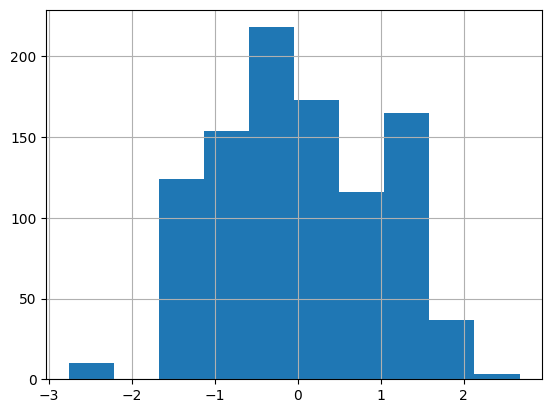

In [57]:
# hist for ged_sb_y_18
train_df_scaled['b_services_efficiency_t48'].hist()

<Axes: >

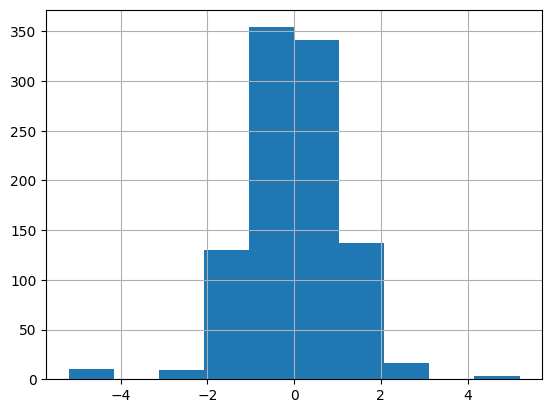

In [61]:
train_df_scaled['b_services_efficiency_t48'].hist()

<Axes: >

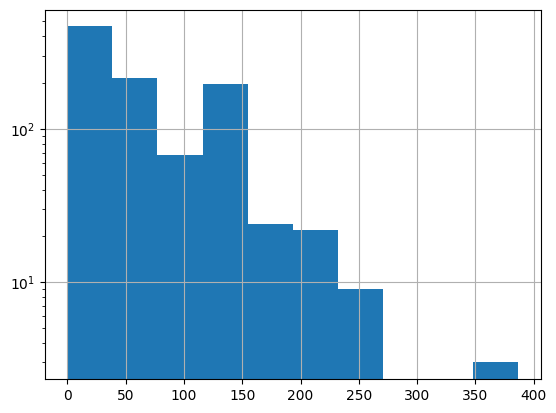

In [60]:
# small_train_df['a_ged_sb'].hist() with log scale
small_train_df['b_services_efficiency_t48'].hist(log=True)